# FPP with Basic U-Net
#### Author: Fernando J. Quintero - Universidad Tecnologica de Bolivar
<br/>


In [3]:
# Basic libraires.
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import pandas as pd

# Tensorflow libraires.
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

# Enabling Tensorboard.
%load_ext tensorboard

from sklearn.model_selection import train_test_split

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
dataset = '../input/single-shot-3d-reconstruction-dataset'
datasetfiles = os.listdir(dataset)
datasetfiles

['X_train_speckle.npy',
 'X_train_fringe.npy',
 'X_test_fringe.npy',
 'Z_train.npy',
 'X_train_double_fringe.npy',
 'Z_test.npy',
 'X_test_double_fringe.npy',
 'hNet.py',
 'X_test_speckle.npy']

In [5]:
fppimgs_train_path = '../input/single-shot-3d-reconstruction-dataset/X_train_fringe.npy'
depth_train_path = '../input/single-shot-3d-reconstruction-dataset/Z_train.npy'

fppimgs_test_path = '../input/single-shot-3d-reconstruction-dataset/X_test_fringe.npy'
depth_test_path = '../input/single-shot-3d-reconstruction-dataset/Z_test.npy'

fppimgs_train = np.load(fppimgs_train_path)
fppimgs_train = np.array(fppimgs_train).astype('float32')
depthmaps_train = np.load(depth_train_path)
depthmaps_train = np.array(depthmaps_train).astype('float32')

fppimgs_test = np.load(fppimgs_test_path)
fppimgs_test = np.array(fppimgs_test).astype('float32')
depthmaps_test = np.load(depth_test_path)
depthmaps_test = np.array(depthmaps_test).astype('float32')

mask_train = depthmaps_train[:,:,:,0]>25
mask_train = mask_train[..., tf.newaxis]
depthmaps_train = np.concatenate((depthmaps_train, mask_train), axis=3)


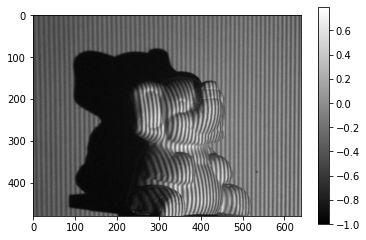

In [9]:
plt.imshow(fppimgs_train[400,:,:,0], cmap = 'gray')
plt.colorbar()
plt.show()

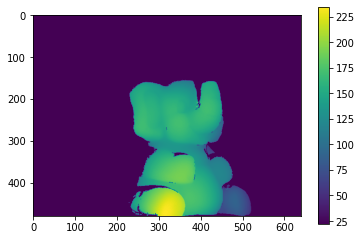

In [7]:
plt.imshow(depthmaps_train[400,:,:,0])
plt.colorbar()
plt.show()

In [10]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 5, padding = "same", kernel_initializer = 'glorot_normal')(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 5, padding = "same", kernel_initializer = 'glorot_normal')(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)
    return x

# Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D(pool_size = 2, strides = 2, padding = 'same')(x)
    #P = Dropout(.2)(p)
    return x, p   


# Decoder block
# skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 5, padding="same", strides=2, kernel_initializer = 'glorot_normal')(input)
    x = Conv2D(num_filters, 5, padding = "same", kernel_initializer = 'glorot_normal')(x)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    #x = Dropout(.2)(x)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512) # Bridge
    b1 = Dropout(.05)( b1)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 5, padding = "same", activation = "linear", kernel_initializer = 'glorot_normal')(d4)  # Binary (can be multiclass)

    model = Model(inputs, outputs, name = "U-Net")
    return model

In [11]:
from sklearn.metrics import mean_squared_error

def rmse(target_y, predicted_y):
    mask = target_y[:,:,:,1] # mask == 0 means background/invalid region
    truth = target_y[:,:,:,0]
    pred = predicted_y[:,:,:,0]
    num = tf.math.multiply(mask, tf.math.squared_difference(truth, pred))
    squared_loss = tf.math.divide(tf.math.reduce_sum(num), tf.math.reduce_sum(mask))
    rmse = tf.sqrt(squared_loss)
    return rmse

def mape(target_y, predicted_y):
    mask = target_y[:,:,:,1] # mask == 0 means background/invalid region
    truth = target_y[:,:,:,0]
    pred = predicted_y[:,:,:,0]
    mape = tf.keras.losses.MeanAbsolutePercentageError(truth, pred).numpy()
    return mape

In [12]:
IMG_HEIGHT = fppimgs_train.shape[1]
IMG_WIDTH  = fppimgs_train.shape[2]
IMG_CHANNELS = fppimgs_train.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model = build_unet(input_shape)
schedule_lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([5000, 10000, 15000, 20000], [ 1e-4, 1e-5, 1e-6, 1e-7, 1e-8])
model.compile(optimizer = RMSprop(learning_rate = schedule_lr), loss = rmse)
model.summary()

model_checkpoint = ModelCheckpoint('./project_model.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
callbacks_list = [model_checkpoint, tf.keras.callbacks.TensorBoard("logs")]

2022-10-21 14:32:57.684184: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 14:32:57.811829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 14:32:57.812601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 14:32:57.813755: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 480, 640, 32) 832         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 480, 640, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 480, 640, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

2022-10-21 14:33:01.101875: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-21 14:33:01.101920: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-21 14:33:01.104162: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-10-21 14:33:01.332682: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-21 14:33:01.332850: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(fppimgs_train, depthmaps_train, test_size = 0.1, random_state=1)

history_model = model.fit(x_train, y_train, 
                          batch_size = 3, epochs = 1, 
                          shuffle  = True, verbose=1, 
                          callbacks = callbacks_list, 
                          validation_data = (x_val, y_val))

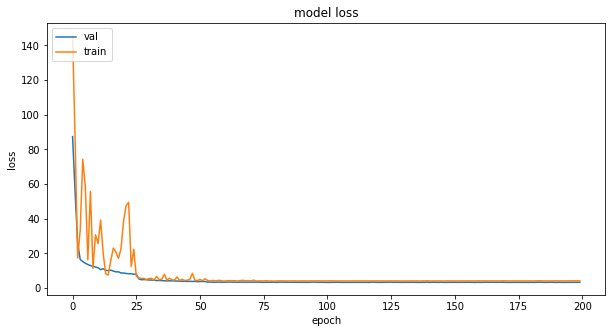

In [17]:
np.array(history_model.history['loss'])
np.array(history_model.history['val_loss'])
fig = plt.figure(figsize=(10,5))
plt.plot(np.array(history_model.history['loss']))
plt.plot(np.array(history_model.history['val_loss']))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.ylim(0, 10)
#plt.xlim(0, 30)
plt.legend(['val', 'train'], loc='upper left')
plt.show()

fig.savefig('loss.png', dpi=fig.dpi)

In [6]:
# loading the saved model
loaded_model = tf.keras.models.load_model('project_model.hdf5', custom_objects={'rmse':rmse})

2022-06-17 01:53:48.706329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2022-06-17 01:53:48.748419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2022-06-17 01:53:48.748828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2022-06-17 01:53:48.750926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2022-06-17 01:53:48.751337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node re

In [7]:
loaded_model.compile(optimizer = RMSprop(learning_rate = 1e-18), loss = rmse)
loaded_model.summary()

Model: "U-Net"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_3 (InputLayer)           [(None, 480, 640, 1  0           []                               

                                )]                                                                

                                                                                                  

 conv2d_46 (Conv2D)             (None, 480, 640, 32  832         ['input_3[0][0]']                

                                )                                                                 

                                                                                                  

 batch_normalization_44 (BatchN  (None, 480, 640, 32  128        ['conv2d_46[0][0]']              

 ormalization)                  )                                                  

In [42]:
!nvidia-smi

Tue Jun 14 15:56:20 2022       

+-----------------------------------------------------------------------------+

| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.6     |

|-------------------------------+----------------------+----------------------+

| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |

| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |

|                               |                      |               MIG M. |

|===============================+======================+======================|

|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |

| 29%   36C    P8     6W / 180W |  15917MiB / 16278MiB |      0%      Default |

|                               |                      |                  N/A |

+-------------------------------+----------------------+----------------------+

                                                                            

In [47]:
history2_model = loaded_model.fit(x_train, y_train, 
                          batch_size = 3, epochs = 100, 
                          shuffle  = True, verbose=1, 
                          callbacks = callbacks_list, 
                          validation_data = (x_val, y_val))

Epoch 1/100

184/184 [==============================] - ETA: 0s - loss: 3.2301

Epoch 00001: val_loss did not improve from 4.00030

184/184 [==============================] - 209s 1s/step - loss: 3.2301 - val_loss: 4.0106

Epoch 2/100

 63/184 [=========>....................] - ETA: 1:34 - loss: 3.2421

KeyboardInterrupt: 

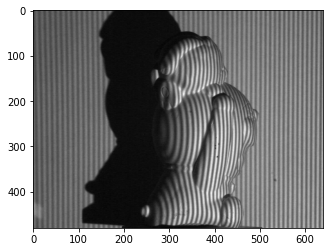

In [87]:
test_image = fppimgs_test[5,:,:,0]
test_image = test_image[..., tf.newaxis]
plt.imshow(test_image, cmap='gray')
plt.savefig('fig1.png', dpi=300)

In [88]:
prueba = test_image[tf.newaxis,...]
predictions = loaded_model.predict(prueba)

In [89]:
mask_test = depthmaps_test[:,:,:,0]>25
mask_test = mask_test[..., tf.newaxis]
depthmaps_test = np.concatenate((depthmaps_test, mask_test), axis=3)

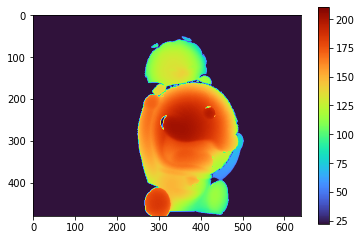

In [84]:
plt.imshow(depthmaps_test[1,:,:,0],cmap='turbo'),plt.colorbar()
plt.savefig('fig2.png', dpi=300)

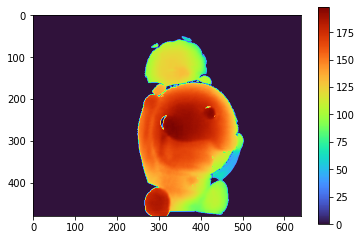

In [85]:
plt.imshow(predictions[0,:,:,0]*depthmaps_test[1,:,:,1],cmap='turbo'),plt.colorbar()
plt.savefig('fig3.png', dpi=300)

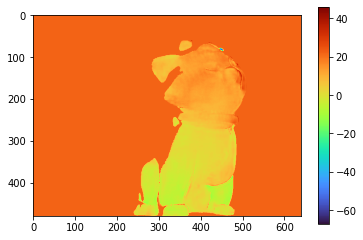

In [55]:
plt.imshow(depthmaps_test[20,:,:,0] - predictions[0,:,:,0]*depthmaps_test[20,:,:,1],cmap='turbo'),plt.colorbar()
plt.savefig('fig4.png', dpi=300)

In [90]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(predictions[0,:,:,0]*depthmaps_test[5,:,:,1], depthmaps_test[5,:,:,0], squared=False)
print(mse)
ErrorRMS = np.sqrt(np.sum((predictions[0,:,:,0]*depthmaps_test[5,:,:,1]-depthmaps_test[5,:,:,0])**2)/(depthmaps_test[20,:,:,0].size))
print(ErrorRMS)

18.993956

19.55045555735211


In [71]:
!pip install scikit-image



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 20.1 MB/s eta 0:00:0000:0100:01






     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 21.2 MB/s eta 0:00:0000:0100:01





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 KB 24.5 MB/s eta 0:00:00



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 22.4 MB/s eta 0:00:0000:0100:01






You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.

